In [1]:
from FarFieldTransfer import *
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import ticker
from matplotlib.colors import SymLogNorm


from cora.signal import corr21cm
from cora.foreground import gaussianfg, galaxy

## Import beam file.

In [2]:
path = "/Users/zhengzhang/PythonProjects/TIBEC/HIRAX_201.txt"
antenna_sph_coords = np.loadtxt(path,
                                comments=('// >>', '361 181', '#'),
                                usecols=(0, 1),
                                max_rows=361 * 181, ).reshape(-1, 2)

antenna_sph_coords = np.deg2rad(antenna_sph_coords)

e_field = (np.loadtxt(path,
                      comments=('// >>', '361 181'),
                      usecols=(2, 4),
                      max_rows=361 * 181,
                      ) 
           + 1j * np.loadtxt(path,
                            comments=('// >>', '361 181'),
                            usecols=(3, 5),
                            max_rows=361 * 181,
                            )).reshape(361, 181, 2)

/var/folders/69/cq4y0nj97qb_376qpg8lsjf80000gn/T/ipykernel_7202/3315045672.py:2: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=65341`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  antenna_sph_coords = np.loadtxt(path,
/var/folders/69/cq4y0nj97qb_376qpg8lsjf80000gn/T/ipykernel_7202/3315045672.py:9: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=65341`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an 

In [3]:
def healpix_map_coordinates(nside):
    npixel = 12 * nside ** 2
    result = np.zeros(shape=(npixel, 2))
    result[:, 1], result[:, 0] = hp.pixelfunc.pix2ang(nside, np.arange(npixel))
    return result

## M-mode formalism

### Settings:
1. Choose the $m$ mode, $m = 140$. 

2. Set $N_{side} =64$ and $l_{max} = 3 * N_{side}  - 1 = 191$.

3. Therefore, $l=140, \dots, 191$. We have $52$ sky degrees of freedom for this $m$ mode.(Or $52*3$ if we take polarizations into consideration.)

4. We assume the antenna scans 221 galactic latitudes.

In [36]:
antenna_latitude = 0. #np.pi/6
nside=64
sky_sph_coords = healpix_map_coordinates(nside)
lmax = 3*nside - 1
n_rings = 301
beam_angles = np.deg2rad(np.linspace(-75., 75., num=n_rings, endpoint=False))
# beam_angles = np.linspace(0.0, 30.0, num=2)

# For m=50:
m = 140
ind_s = hp.sphtfunc.Alm.getidx(lmax, m, m)
ind_e = hp.sphtfunc.Alm.getidx(lmax, lmax, m)
N_s = ind_e + 1 - ind_s

test = E_field_thesis(antenna_sph_coords, e_field, antenna_latitude)

print("m:{}, lmax:{}, N_s:{}. \n".format(m, lmax, N_s))
assert n_rings > 3*N_s

The far-field object has been initialized!
m:140, lmax:191, N_s:52. 



### Generate beam files.
"Beam_maps": healpix maps of the beam.

"Beam_matrix": spherical harmonic coefficients of the beam ($m=140$, $l=140, \dots, 191$.)

In [37]:
Beam_maps, Beam_matrix = test.generate_multipole_beams(sky_sph_coords, beam_angles) # (n_rings, n_pol, N_s)

In [38]:
norm = np.average(np.sum(Beam_maps, axis = -1)[ :, 0])
Beam_matrix = np.array(Beam_matrix)
Beam_matrix_a = Beam_matrix[:, :, ind_s: ind_e + 1].reshape(-1, 3*N_s) / norm
Beam_matrix_i = Beam_matrix[:, 0, ind_s: ind_e + 1].reshape(-1, N_s) / norm
Beam_matrix_p = Beam_matrix[:, 1:, ind_s: ind_e + 1].reshape(-1, N_s*2) / norm

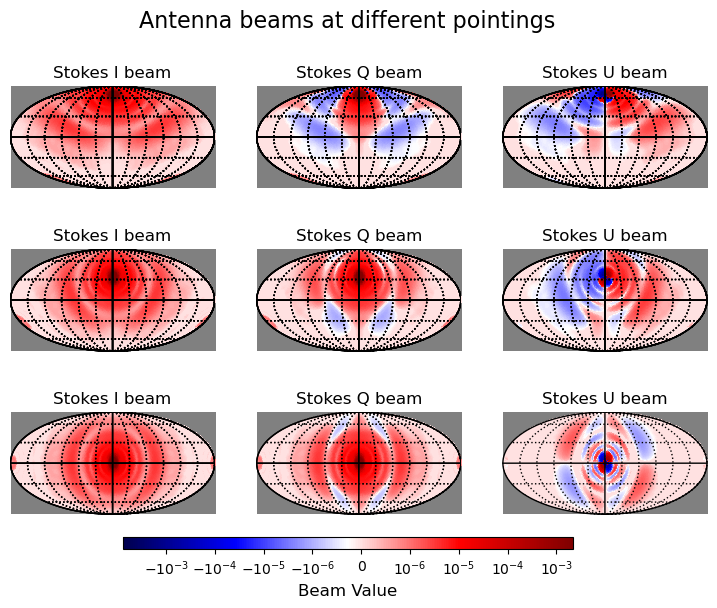

In [47]:
def plot_beam_xx(Beam, pointings, saveAs=None): 
    """ 
    beam: (n_rings, n_pol, N_s)  ---> (XX/YY, pointings, polari, pixels)
    """
    fig, axs = plt.subplots(3, 3, figsize=(9, 6))
    fig.suptitle('Antenna beams at different pointings'.format(antenna_latitude), fontsize=16)
    pols = ["I", "Q", "U"]

    # Calculate global vmin and vmax
    vmin = np.min(Beam[ :, :, :])
    vmax = np.max(Beam[ :, :, :])

    # Use SymLogNorm for normalization
    linthresh = 1e-7  # Adjust if necessary, it defines the range around zero which is handled linearly
    norm = SymLogNorm(linthresh=linthresh, linscale=linthresh, base=10, vmin=vmin, vmax=vmax)

    for i in range(3):
        l = pointings[i]
        for P in range(3):
            plt.axes(axs.flat[3*i+P])
            hp.mollview(Beam[l, P, :],
                        title="Stokes "+pols[P]+" beam",
                        rot=(0, 0, 0),
                        hold=True,
                        cmap='seismic',
                        cbar=None,  # no colorbar for each subplot
                        norm=norm)  # Using SymLogNorm here
            hp.visufunc.graticule(coord='C')

    # Add a single colorbar using the SymLogNorm normalization
    cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.02]) 
    cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='seismic'), cax=cbar_ax, orientation='horizontal')
    ticks = [ -1e-3, -1e-4, -1e-5, -1e-6, 0, 1e-6, 1e-5, 1e-4, 1e-3]  # Example tick values
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([str(tick) for tick in ticks])  # You can further customize the tick labels if needed
    
    def format_func(value, tick_number):
        # format the tick labels to '10^x' or '-10^x' format
        if value == 0:
            return "0"
        exponent = int(np.log10(abs(value)))
        return r"${}10^{{{:d}}}$".format('-' if value < 0 else '', exponent)

    cbar.ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_func))

    cbar.set_label('Beam Value', fontsize=12)

    plt.subplots_adjust(bottom=0.2)  # Adjust to make room for the colorbar

    if saveAs is not None:
        fig.savefig("./{}.png".format(saveAs))
    
    return


pointing = [20, 85, 150]
plot_beam_xx(Beam_maps/norm, pointing, saveAs="antenna_Stokes_beams")

## Define estimators


Measurement equation:
\begin{equation}
\begin{split}
    \boldsymbol{d}&=\mathbf{M}\,\boldsymbol{s} +  \boldsymbol{n} \\
    &=\mathbf{A}\boldsymbol{i} + \mathbf{B}\boldsymbol{p} + \boldsymbol{n}  \\
\end{split}
\end{equation}

### 1. Solving for all sky degrees of freesom, including Stokes I, Q, U.

MLE:
\begin{equation}
    \hat{\boldsymbol{s}}=\mathbf{K}\,\boldsymbol{d},
\end{equation}
where
\begin{equation}
    \mathbf{K} = (\mathbf{M}^\dagger \mathbf{N}^{-1} \mathbf{M})^{-1}\mathbf{M}^\dagger\mathbf{N}^{-1}
\end{equation}

Then $\hat{\boldsymbol{i}}$ can be extracted from $\hat{\boldsymbol{s}}$.

### 2. Solving for Stokes I, taking the polarized sky as noise components decribed by $C_{P}$:

MLE:
\begin{equation}
    \hat{\boldsymbol{i}} = \mathbf{K} \boldsymbol{d}
\end{equation}
where
\begin{equation}
    \mathbf{K} = \left[\mathbf{A}^\dagger {\left(\mathbf{B} C_{P}\mathbf{B}^\dagger+\mathbf{N}\right)}^{-1} \mathbf{A}\right]^{-1}\mathbf{A}^\dagger{\left(\mathbf{B} C_{P}\mathbf{B}^\dagger+\mathbf{N}\right)}^{-1}
\end{equation}

### 3. Solving for Stokes I, with the polarization integrated out in the likelihood:
MLE:
\begin{equation}
    \hat{\boldsymbol{i}} = \mathbf{K} \boldsymbol{d}= -\mathcal{C}_{ii}\mathbf{U}\boldsymbol{d}
\end{equation}
where 
\begin{equation}
    \mathcal{C}_{ii}= \left[ { \mathbf{A}^T \mathbf{N}^{-1} \mathbf{A}}  - \mathbf{A}^T\mathbf{N}^{-1}\mathbf{B}
    (\mathbf{B}^T\mathbf{N}^{-1}\mathbf{B} )^{-1}
    \mathbf{B}^T\mathbf{N}^{-1}\mathbf{A} \right]^{-1}
\end{equation}
and
\begin{equation}
    \mathbf{U}=\mathbf{A}^T\mathbf{N}^{-1} - \mathbf{A}^T\mathbf{N}^{-1}\mathbf{B}
    (\mathbf{B}^T\mathbf{N}^{-1}\mathbf{B} )^{-1}
    \mathbf{B}^T\mathbf{N}^{-1}
\end{equation}

### 4. Solving for Stokes I with a prior, with polarization integrated out in the posterior:
MAP:
\begin{equation}
    \hat{\boldsymbol{i}} = \mathbf{K} \boldsymbol{d} = \mathcal{C}_{ii}\mathbf{U}\boldsymbol{d}
\end{equation}
where 
\begin{equation}
    \mathcal{C}_{ii}= \left[ \mathbf{C}_I^{-1} {+ \mathbf{A}^T \mathbf{N}^{-1} \mathbf{A}}  - \mathbf{A}^T\mathbf{N}^{-1}\mathbf{B}
    (\mathbf{B}^T\mathbf{N}^{-1}\mathbf{B} + \mathbf{C}_P^{-1})^{-1}
    \mathbf{B}^T\mathbf{N}^{-1}\mathbf{A} \right]^{-1}
\end{equation}
and
\begin{equation}
    \mathbf{U}=\mathbf{A}^T\mathbf{N}^{-1} - \mathbf{A}^T\mathbf{N}^{-1}\mathbf{B}
    (\mathbf{B}^T\mathbf{N}^{-1}\mathbf{B} + \mathbf{C}_P^{-1})^{-1}
    \mathbf{B}^T\mathbf{N}^{-1}
\end{equation}

## Variance:
\begin{equation}
    var(\hat{\boldsymbol{i}}) \equiv \langle \hat{\boldsymbol{i}} \hat{\boldsymbol{i}}^\dagger\rangle - \langle {\boldsymbol{i}} {\boldsymbol{i}}^\dagger\rangle
    = \mathbf{K} N \mathbf{K}^\dagger 
\end{equation}
\begin{equation}
    var(\hat{\boldsymbol{i}}) \equiv \langle \hat{\boldsymbol{i}} \hat{\boldsymbol{i}}^\dagger\rangle - \langle {\boldsymbol{i}} {\boldsymbol{i}}^\dagger\rangle
    = \mathbf{K} \boldsymbol{d} \boldsymbol{d}^\dagger \mathbf{K}^\dagger - \mathbf{C}_I
\end{equation}

## Bias:
\begin{equation}
    b(\hat{\boldsymbol{i}}) \equiv  
    \mathbf{K}(\mathbf{A}\boldsymbol{i} + \mathbf{B}\boldsymbol{p}) - \boldsymbol{i}
\end{equation}
If we consider effect gain mismatch
\begin{equation}
    b(\hat{\boldsymbol{i}}) \equiv  
    \mathbf{K}\mathbf{G}(\mathbf{A}\boldsymbol{i} + \mathbf{B}\boldsymbol{p}) - \boldsymbol{i}
\end{equation}
where
\begin{equation}
 \mathbf{G}= 
 \begin{pmatrix}
     1+g_1 & & \\
     & \ddots & \\
     & &  1+g_n
 \end{pmatrix}
\end{equation}

In [40]:
def maximum_likelihood_operator(b_matr, noise_cov):
    n_inv = np.linalg.inv(noise_cov)
    K = np.linalg.inv(b_matr.conj().T @ n_inv @ b_matr) @ b_matr.conj().T @ n_inv
    return K

def MLE_oper_pol_as_noise(matr_A, matr_B, noise_cov, Cp):
    matr_noise = matr_B @ Cp @ matr_B.conj().T + noise_cov
    return maximum_likelihood_operator(matr_A, matr_noise)

def MLE_oper_marginalize_pol(matr_A, matr_B, noise_cov, Ci, Cp):
    n_inv = np.linalg.inv(noise_cov)
    aux1 = np.linalg.inv(matr_B.conj().T @ n_inv @ matr_B + np.linalg.inv(Cp))
    aux2 = matr_A.conj().T @ n_inv @ matr_B
    aux3 = matr_B.conj().T @ n_inv
    U = matr_A.conj().T @ n_inv - aux2 @ aux1 @ aux3
    C_ii_inv = np.linalg.inv(Ci) + U@matr_A 
    C_ii = np.linalg.inv(C_ii_inv)
    K =  C_ii@U
    return K

def MLE_oper_marginalize_pol_wo_prior(matr_A, matr_B, noise_cov):
    n_inv = np.linalg.inv(noise_cov)
    aux1 = np.linalg.inv(matr_B.conj().T @ n_inv @ matr_B)
    aux2 = matr_A.conj().T @ n_inv @ matr_B
    aux3 = matr_B.conj().T @ n_inv
    U = matr_A.conj().T @ n_inv - aux2 @ aux1 @ aux3
    C_ii_inv = U@matr_A 
    K =  np.linalg.inv(C_ii_inv)@U
    return K

def calc_var_1(K, noise_cov):
    var = K @ noise_cov @ K.conj().T
    return np.diagonal(var.real)

def calc_var_2(K, matr_A, matr_B, noise_cov, Cii, Cpp):
    aux1 = K@matr_A 
    aux2 = K@matr_B 
    estimator_cov= aux1 @ Cii @ aux1.conj().T + aux2 @ Cpp @ aux2.conj().T + K@noise_cov@K.conj().T
    var = estimator_cov[:N_s,:N_s] - Cii
    return np.diagonal(var.real)

def plot_variance(variance, variance_pr, saveAs=None):
    fig, axs = plt.subplots(1, 1, figsize=(10, 6))
    #fig.suptitle('Antenna latitude: {} rad, LST: 0h00'.format(antenna_latitude), fontsize=16)
    #pols = ["T", "Q", "U", "V"]
    plt.plot(np.log(variance), label='w pol')
    plt.plot(np.log(variance_pr), label='wo pol')
    plt.legend()
    if saveAs is not None:
        fig.savefig("./{}.png".format(saveAs))
    return

## Input PS

In [41]:
freq = 400.
pol_frac = 0.6

fsyn = galaxy.FullSkySynchrotron()
fpol = galaxy.FullSkyPolarisedSynchrotron()
cv_fg_i = np.zeros(N_s)
cv_fg_p = np.zeros((2, N_s))
for i in range(N_s):
    l = m + i
    cv_fg_i[i] = fsyn.angular_powerspectrum(l, freq, freq)
    cv_fg_p[0, i] = pol_frac * fpol.angular_powerspectrum(l, freq, freq)
    cv_fg_p[1, i] = pol_frac * fpol.angular_powerspectrum(l, freq, freq)
    
C_i_i = np.diag(cv_fg_i)
C_p_p = np.diag(cv_fg_p.reshape(-1))


## Variance as $KNK^\dagger$:

In [42]:
def calc_total_sky_component(matr_A, matr_B, Cii, Cpp):
    aux = matr_A @ Cii @ matr_A.conj().T + matr_B @ Cpp @ matr_B.conj().T 
    sigm = np.average(np.diag(aux))
    return sigm.real

SNR = 200
sigma = calc_total_sky_component(Beam_matrix_i, Beam_matrix_p, C_i_i, C_p_p) / SNR
#sigma = np.average(np.diagonal(C_i_i).real)
N_cov = np.identity(Beam_matrix_a.shape[0]) * sigma
print("sigma: {}".format(sigma))

sigma: 1.2177380119335494e-16


In [43]:
# 1. MLE (solving for Stokes I together with polarization):

K1 = maximum_likelihood_operator(Beam_matrix_a, N_cov)
variance_a_1 = calc_var_1(K1, N_cov)[:N_s]
variance_a_2 = calc_var_2(K1, Beam_matrix_i, Beam_matrix_p, N_cov, C_i_i, C_p_p)[:N_s]

#  MLE (rejecting/marginalizing polarization):
K2 = MLE_oper_marginalize_pol_wo_prior(Beam_matrix_i, Beam_matrix_p, N_cov)
variance_b_1 = calc_var_1(K2, N_cov)
variance_b_2 = calc_var_2(K2, Beam_matrix_i, Beam_matrix_p, N_cov, C_i_i, C_p_p)

# 2. MLE (taking polarization as noise.):
K3 = MLE_oper_pol_as_noise(Beam_matrix_i, Beam_matrix_p, N_cov, C_p_p)
variance_c_1 = calc_var_1(K3, N_cov)
variance_c_2 = calc_var_2(K3, Beam_matrix_i, Beam_matrix_p, N_cov, C_i_i, C_p_p)

# 3. MAP (marginalizing polarization with priors):
K4 = MLE_oper_marginalize_pol(Beam_matrix_i, Beam_matrix_p, N_cov, C_i_i, C_p_p)
variance_d_1 = calc_var_1(K4, N_cov)
variance_d_2 = calc_var_2(K4, Beam_matrix_i, Beam_matrix_p, N_cov, C_i_i, C_p_p)



/var/folders/69/cq4y0nj97qb_376qpg8lsjf80000gn/T/ipykernel_7202/1976947285.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot(x, fiducial_y, 'k--', zorder=0, color='gray', linewidth=0.8)


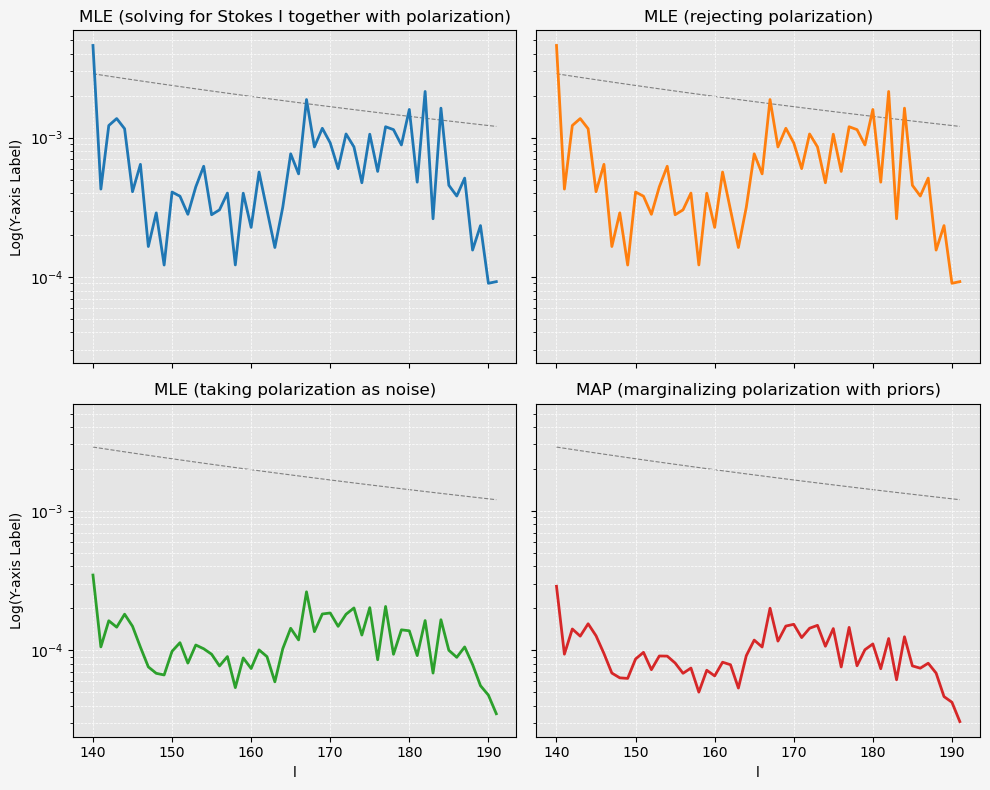

In [44]:
# Sample data
x = np.arange(m, lmax+1)
y1 = np.abs(variance_a_2)
y2 = np.abs(variance_b_2)
y3 = np.abs(variance_c_2)
y4 = np.abs(variance_d_2)

fiducial_y = np.diagonal(C_i_i)  # Fiducial plot: y = x

# Setting up a color palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
bg_color = '#f5f5f5'
plot_bg_color = '#e5e5e5'

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 8))
fig.patch.set_facecolor(bg_color)

# Plot data in each subplot with the fiducial line
for i, ax in enumerate(axs.flat):
    # Fiducial plot
    ax.plot(x, fiducial_y, 'k--', zorder=0, color='gray', linewidth=0.8)
    
    # Set background color and grid for each subplot
    ax.set_facecolor(plot_bg_color)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='white')
    
    # Primary plots with enhanced color
    ax.plot(x, [y1, y2, y3, y4][i], color=colors[i], linewidth=2)
    ax.set_yscale('log')

# Titles
axs[0, 0].set_title('MLE (solving for Stokes I together with polarization)')
axs[0, 1].set_title('MLE (rejecting polarization)')
axs[1, 0].set_title('MLE (taking polarization as noise)')
axs[1, 1].set_title('MAP (marginalizing polarization with priors)')

for ax in axs[1, :]:  # Bottom row for x label
    ax.set_xlabel('l')

for ax in axs[:, 0]:  # First column for y label
    ax.set_ylabel('Log(Y-axis Label)')


# Display the figure
plt.tight_layout()
plt.show()


/var/folders/69/cq4y0nj97qb_376qpg8lsjf80000gn/T/ipykernel_7202/1924774635.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot(x, fiducial_y, 'k--', zorder=0, color='gray', linewidth=0.8, label='$C_\ell^{\mathbf{I}}$')


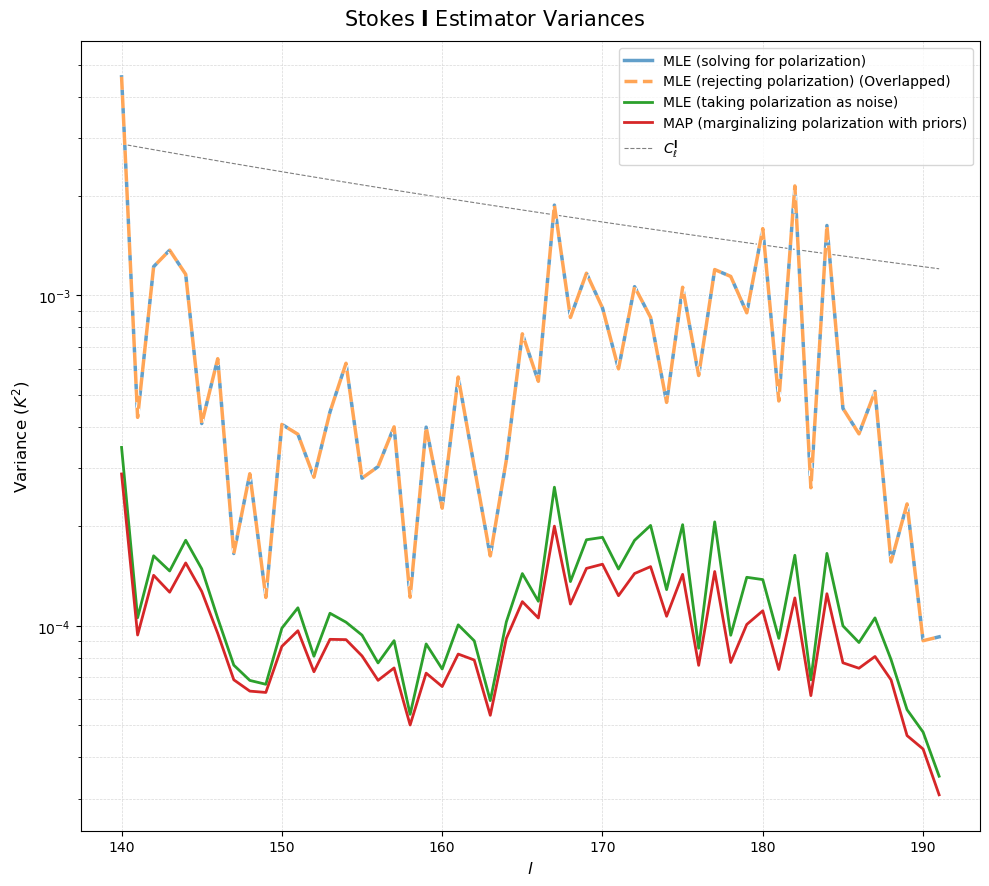

In [48]:
from matplotlib.patheffects import withStroke

# Colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Create a single plot
fig, ax = plt.subplots(figsize=(10, 9))

# Adjusting background and grid lines
ax.set_facecolor('white')  # White background
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='#d9d9d9')  # Lighter grid lines

# Edge effect
pe = [withStroke(linewidth=4, foreground="w")]

# Plot data with enhancements for overlap
ax.plot(x, y1, color=colors[0], linewidth=2.5, label='MLE (solving for polarization)', alpha=0.7, path_effects=pe)
ax.plot(x, y2, color=colors[1], linewidth=2.5, linestyle='--', label='MLE (rejecting polarization) (Overlapped)', alpha=0.7, path_effects=pe)

ax.plot(x, y3, color=colors[2], linewidth=2, label='MLE (taking polarization as noise)')
ax.plot(x, y4, color=colors[3], linewidth=2, label='MAP (marginalizing polarization with priors)')

# Fiducial plot
ax.plot(x, fiducial_y, 'k--', zorder=0, color='gray', linewidth=0.8, label='$C_\ell^{\mathbf{I}}$')

# Set yscale to log
ax.set_yscale('log')

# Set x and y labels
ax.set_xlabel('$l$',  fontsize=12)
ax.set_ylabel('Variance ($K^2$)',  fontsize=12)

# Add legend
ax.legend()

fig.suptitle('Stokes $\mathbf{I}$ Estimator Variances',  fontsize=15)

plt.tight_layout()
plt.savefig('Stokes_I_esti_var.png')
plt.show()



In [46]:

# 
"""
# With Polarization (image of I):
Ui, Si, Vhi = np.linalg.svd(Beam_matrix_i_m50)
projector_i_image = Ui[:, :len(S[mask])].conj().T
noise_cov_image = projector_i_image@noise_cov@projector_i_image.conj().T
K_image = maximum_likelihood_operator(projector_i_image@Beam_matrix_m50, noise_cov_image)
variance = K_image @ noise_cov_image @ K_image.conj().T  # shape: (3N_s, 3N_s)
variance = variance[:N_s,:N_s]
"""

# Project out Polarization:
U, S, Vh = np.linalg.svd(Beam_matrix_p_m50)
mask = S > S[0] * 0.0001
# len(S[mask])
projector = U[:, len(S[mask]):].conj().T
#Beam_matrix_m50_p_rejected = projector @ Beam_matrix_m50
noise_cov_p_rejected = projector @ noise_cov @ projector.conj().T  
#K_pr = maximum_likelihood_operator(Beam_matrix_m50_p_rejected, noise_cov_p_rejected)
#variance_pr = K_pr @ noise_cov_p_rejected @ K_pr.conj().T  
#variance_pr = variance_pr[:N_s,:N_s]


Beam_matrix_m50_p_rejected_2 = projector @ Beam_matrix_i_m50
K_pr_2 = maximum_likelihood_operator(Beam_matrix_m50_p_rejected_2, noise_cov_p_rejected)
variance_pr_2 = K_pr_2 @ noise_cov_p_rejected @ K_pr_2.conj().T  


NameError: name 'Beam_matrix_p_m50' is not defined

In [ ]:
#plot_variance(np.diagonal(variance.real), np.diagonal(variance_pr.real))

In [ ]:
plt.plot(np.diagonal(C_i_i))

In [ ]:
def P_delta_beam(K, delta_B_I, delta_B_P, C_I_I, C_P_P):
    aux = delta_B_I@C_I_I@delta_B_I.conj().T + delta_B_P@C_P_P@delta_B_P.conj().T
    result = K@delta_B_I@C_I_I + C_I_I@delta_B_I.conj().T@K.conj().T + K @ aux @ K.conj().T 
    return result

delta_B_I = 0.2 * Beam_matrix_i + 0.1 * Beam_matrix_p.reshape(Beam_matrix_i.shape[0], 2, -1)[:,0,:]
delta_B_P = 0.2 * Beam_matrix_p 
delta_B_P[:,:N_s] += 0.1*delta_B_I

P_delta_B = P_delta_beam(K2, delta_B_I, delta_B_P, C_i_i, C_p_p)
plt.plot(np.diag(P_delta_B).real, color="green")
plt.plot(np.diag(C_i_i).real, color="orange")

In [ ]:
np.degrees(0.05)

In [ ]:
Beam_maps.shape